In this notebook we'll explore the solution found by our classifier.

In [38]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import utils

%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
%autoreload
import utils

In [40]:
# Pick a model to load and extract the hyperparams.

model_name = 'models/64_64_32_0.0_False_100_10000_0.1_64_002_0.23935_0.78176.h5'

gru_dim, embed_dim, dense_dim, dropout, bidirectional, maxlen, topn, test_size, batch_size = \
  utils.parse_model_name(model_name)

In [41]:
# Load the keras model

model = load_model(model_name)

In [42]:
%%time

filepath = '../data/data-False-3.pkl'

df, keep_stops, min_sents, vocab, w2i, i2w = utils.read_dataset(filepath)

CPU times: user 32.3 s, sys: 570 ms, total: 32.8 s
Wall time: 32.9 s


In [43]:
%%time

# Filter out uncommon words.

df['encoded_text'] = utils.filter_top_words(list(df['encoded_text']), topn)

CPU times: user 2.32 s, sys: 51.1 ms, total: 2.38 s
Wall time: 2.37 s


In [44]:
X = pad_sequences(df['encoded_text'], maxlen=maxlen, value=topn, 
                  padding='post', truncating='post')

Y = df['encoded_label'].tolist()

In [45]:
# Get output probabilities for every observation.

df['prob'] = model.predict(X)

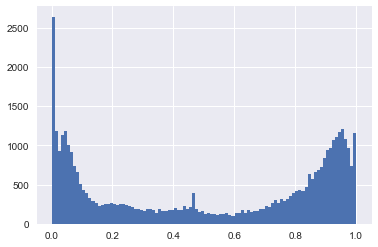

In [46]:
# Look at distribution.  There are some funny extreme modes we should try to understand,
# and a significant percentage of more "netural" labels.

_ = df['prob'].hist(bins=100)

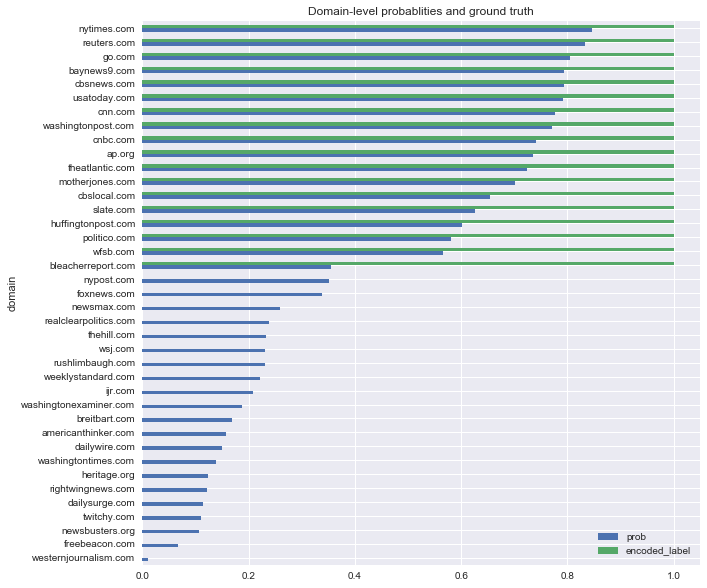

In [47]:
# Groupby domain name and take the average probability.  We can then round to 0/1 to 
# get a domain-level classification.

drop_less_than = 10  # Drop domains with fewer than this many observations

df_mean = df.groupby('domain')['encoded_label', 'prob'].mean()
df_count = df.groupby('domain')['domain'].count()
df_stats = pd.concat([df_mean, df_count], axis=1).sort_values('prob')
df_stats['num_correct'] = df_stats.apply(lambda x: int(np.round(x['prob'])) == x['encoded_label'], axis=1)
df_stats = df_stats[df_stats['domain'] >= drop_less_than]

_ = df_stats[['prob', 'encoded_label']].plot(kind='barh', figsize=(10,10), 
      title='Domain-level probablities and ground truth')

In [49]:
# Count the number of correct domain-level classifications.
tf = df_stats.groupby('num_correct')['prob'].count()
print('Domain-level accuracy: {:1.1f}%'.format(100.*tf[True]/tf.sum()))

Domain-level accuracy: 97.4%
